In [1]:
import sys
if not './' in sys.path:
    sys.path.append('./')

In [2]:
import tensorflow as tf

# from tensorflow.keras.mixed_precision import experimental as mixed_precision
import pandas as pd
import numpy as np
import io
import os
from datetime import datetime
import time

from envs.stocks_env_multiaction import Stocks_env
from datasets import nyse
from models.lstm_selfattention_embedding import ActorCritic

from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

<h2>Use GPU</h2>

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
              tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)
        
print(tf.config.experimental.list_logical_devices('GPU'))
tf.test.is_gpu_available()

# set up policy used in mixed precision
# from tensorflow.keras.mixed_precision import experimental as mixed_precision
# policy = mixed_precision.Policy('mixed_float16')
# mixed_precision.set_policy(policy)

1 Physical GPUs, 1 Logical GPUs
[LogicalDevice(name='/device:GPU:0', device_type='GPU')]
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

<h2>Load Data</h2>

In [4]:
#data = nyse.load_data('../data/')
data, tokenized_industry, vocabulary_size = nyse.load_data_with_industry('../data/', column='GICS Sector')
# data, tokenized_industry, vocabulary_size = nyse.load_data_with_industry('../data/', column='GICS Sub Industry')

<h2>GAE and PPO</h2>

In [5]:
def compute_gae(next_value, rewards, masks, values, gamma=0.99, tau=0.95):
    values = values + [next_value]
    gae = 0
    returns = []
    for step in reversed(range(len(rewards))):
        delta = rewards[step] + gamma * values[step + 1] * masks[step] - values[step]
        gae = delta + gamma * tau * masks[step] * gae
        returns.insert(0, gae + values[step])
    return returns

In [6]:
def ppo_iter(mini_batch_size, states_daily, states_industry, actions, log_probs, returns, advantage):
    batch_size = tf.shape(states_daily)[0]
    for _ in range(batch_size // mini_batch_size):
        rand_ids = np.random.randint(0, batch_size, mini_batch_size)
        yield states_daily.numpy()[rand_ids, :], np.array(states_industry)[rand_ids, :], actions.numpy()[rand_ids, :], log_probs.numpy()[rand_ids, :], returns.numpy()[rand_ids, :], advantage.numpy()[rand_ids, :]

def ppo_update(ppo_epochs, mini_batch_size, states_daily, states_industry, actions, log_probs, returns, advantages, clip_param=0.2):
    for _ in range(ppo_epochs):
        for state_daily, state_industry, action, old_log_probs, return_, advantage in ppo_iter(mini_batch_size, states_daily, states_industry, actions, log_probs, returns, advantages):
            with tf.GradientTape() as tape:
                # value, dist = model(state, np.reshape(state[:,-1,:],(batch_size, 1, num_inputs[1])))
                value, dist = model(state_daily, state_industry)

                entropy = tf.math.reduce_mean(dist.entropy())
                new_log_probs = dist.log_prob(action)

                ratio = tf.math.exp(new_log_probs - old_log_probs)
                surr1 = ratio * advantage
                surr2 = tf.clip_by_value(ratio, clip_value_min=1.0 - clip_param, 
                                         clip_value_max=1.0 + clip_param) * advantage

                actor_loss  = - tf.math.reduce_mean(tf.math.minimum(surr1, surr2))
                critic_loss = tf.math.reduce_mean(tf.math.pow(return_ - value, 2))

                loss = 0.5 * critic_loss + actor_loss - 0.001 * entropy

            gradients = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(gradients, model.trainable_variables))

<h2>Training Parameters</h2>

In [7]:
# Hyper params:
lr               = 1e-4
rs               = 1
run_lenght       = 10
batch_size       = 256
window_size      = 5
ppo_epochs       = 4
num_epochs       = 800
test_iterations  = 1
hidden_dim       = 256
kernel_size      = 7
num_filters      = 128
lstm_units       = 512
num_blocks       = 1
embedding_out    = 6
in_lstm_units    = 16
initial_money    = 100
test_seed        = 42
model_filename   = None
with_hold        = False
actor_activation = False

# log
log_freq = 10
save_freq = 40
models_directory = 'results/models/'
save_directory = 'results/saved-timesteps/'
date = datetime.now().strftime("%Y_%m_%d-%H:%M:%S")
identifier = "stonks-" + date
test_summary_writer = tf.summary.create_file_writer('results/summaries/test/' + identifier)
mean_test_reward = tf.keras.metrics.Mean(name='mean_test_reward')
mean_train_reward = tf.keras.metrics.Mean(name='mean_train_reward')

<h2>Create Enviroment</h2>

In [8]:
# initialize env
env = Stocks_env(data, window_size, run_lenght, batch_size=batch_size, with_hold=with_hold,
                 tokenized_industry=tokenized_industry, test_seed=test_seed, initial_money=initial_money)

# test parameters
test_batch_size  = len(env.get_test_symbols())
unique_symbols = data.symbol.unique()
mini = 999
for symbol in unique_symbols:
    if len(data[data.symbol==symbol]) < mini:
        mini = len(data[data.symbol==symbol])
# test_run_lenght = run_lenght
test_run_lenght = mini-window_size-1
test_initial_money = initial_money
# test_batch_size  = batch_size

# inputs and policies
num_inputs  = env.get_observation_space()
num_policies = env.get_action_space()

<h2>Create Model</h2>

In [9]:
# initialize the model
model = ActorCritic(num_policies = num_policies, hidden_dim=hidden_dim, num_filters=num_filters, actor_activation=actor_activation, 
                    lstm_units=lstm_units, text_lenght=tokenized_industry.shape[1], kernel_size=kernel_size,
                    vocabulary_size=vocabulary_size, embedding_out=embedding_out, in_lstm_units = in_lstm_units)
optimizer = tf.keras.optimizers.Adam(lr)
if model_filename:
    state = env.reset()
    model(state[0], state[1])
    model.load_weights(models_directory + model_filename + '.h5')

<h2>Train</h2>

In [10]:
def plot(epochs, rewards_train, rewards_test):
    clear_output(True)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,5))
    fig.suptitle('frame %s. ' % epochs[-1])
    ax1.set_title('train. reward: %s' % rewards_train[-1])
    ax1.plot(epochs, rewards_train)
    ax2.set_title('test. reward: %s' % rewards_test[-1])
    ax2.plot(epochs, rewards_test)
    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    buf.seek(0)
    image = tf.image.decode_png(buf.getvalue(), channels=4)
    image = tf.expand_dims(image, 0)
    plt.show()
    return image

def test_env(record_days=False, random_reset=True, run_lenght=20):
    state = env.reset(training=False, batch_size=test_batch_size, run_lenght=run_lenght, 
                      initial_money=test_initial_money, random_reset=random_reset)
    done = False
    operation_array = []
    days_array = []
    rewards_array = []
    total_profit = np.zeros(test_batch_size)
    while not done:
        # _, dist = model(state, np.reshape(state[:,-1,:],(test_batch_size, 1, num_inputs[1])))
        _, dist = model(state[0], state[1])
        next_state, reward, done, operations, day, profit = env.step(dist.sample())
        state = next_state
        if record_days:
            operation_array.append(np.array(operations))
            days_array.append(np.array(day))
            rewards_array.append(np.array(reward))
        mean_test_reward(np.array(reward))
        total_profit += profit
    total_profit = total_profit/test_initial_money
    return operation_array, days_array, rewards_array, total_profit

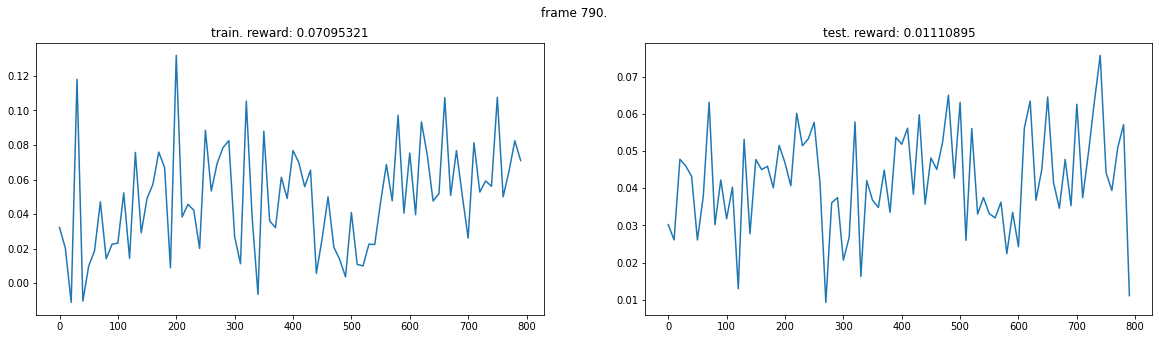

70.31058979034424


In [11]:
train_rewards = []
test_rewards = []
total_profits = []
test_total_profits = []
best_test = 0
epoch  = 0
epochs = []

start = time.time()
while epoch < num_epochs:
    
    log_probs = []
    values    = []
    states_daily = []
    states_industry = []
    actions   = []
    rewards   = []
    masks     = []
    total_profit = np.zeros(batch_size)

    state = env.reset(training=True, batch_size=batch_size, run_lenght=run_lenght, initial_money=initial_money)

    done = False
    while not done:
        value, dist = model(state[0], state[1])

        action = dist.sample()
        next_state, reward, done, _, _, profit = env.step(action)
        mean_train_reward(reward)
        reward = reward*rs

        log_prob = dist.log_prob(action)

        log_probs.append(log_prob)
        values.append(np.array(value))
        rewards.append(tf.dtypes.cast(tf.expand_dims((reward,), axis=1), tf.float32))
        masks.append(tf.expand_dims((float(1 - done),), axis=1))
        
        total_profit += profit

        states_daily.append(state[0])
        states_industry.append(state[1])
        actions.append(action)

        state = next_state

    # next_value, _ = model(next_state, np.reshape(next_state[:,-1,:],(batch_size, 1, num_inputs[1])))
    next_value, _ = model(next_state[0], next_state[1])
    returns = compute_gae(next_value, rewards, masks, values)

    returns_save = returns

    returns   = tf.reshape(tf.concat(returns, axis=1),(run_lenght*batch_size,-1))
    log_probs = tf.concat(log_probs, axis=0)
    values    = tf.concat(values, axis=0)
    states_daily    = tf.concat(states_daily, axis=0)    
    states_industry = tf.reshape(states_industry,(run_lenght*batch_size,-1))
    actions   = tf.reshape(tf.concat(actions, axis=0),(run_lenght*batch_size,-1))

    advantage = returns - values
    advantage = tf.reshape(advantage,(run_lenght*batch_size**2,1))

    ppo_update(ppo_epochs, batch_size, states_daily, states_industry, actions, log_probs, returns, advantage)

    if epoch % log_freq == 0:
        for i in range(test_iterations):
            operation_array, days_array, rewards_array, test_total_profit = test_env(
                record_days=(i==test_iterations-1), random_reset=False, run_lenght=test_run_lenght)
        total_profits.append(total_profit/initial_money)
        test_total_profits.append(test_total_profit)
        train_rewards.append(mean_train_reward.result().numpy())
        test_rewards.append(mean_test_reward.result().numpy())
        epochs.append(epoch)
        with test_summary_writer.as_default():
            tf.summary.scalar('mean_test_reward', mean_test_reward.result(), step=epoch)
            tf.summary.scalar('mean_train_reward', mean_train_reward.result(), step=epoch)
            tf.summary.image('Plot', plot(epochs, train_rewards, test_rewards), step=epoch)
        # serialize weights to HDF5
        if not os.path.exists(save_directory):
            os.makedirs(save_directory)
        if not os.path.exists(save_directory+'/operation/'):
            os.makedirs(save_directory+'/operation/')
        if not os.path.exists(save_directory+'/endingday/'):
            os.makedirs(save_directory+'/endingday/')
        if not os.path.exists(save_directory+'/rewards/'):
            os.makedirs(save_directory+'/rewards/')
        if not os.path.exists(save_directory+'/profits/'):
            os.makedirs(save_directory+'/profits/')
        if not os.path.exists(save_directory+'/test-profits/'):
            os.makedirs(save_directory+'/test-profits/')
        pd.DataFrame(operation_array).to_csv(save_directory+"/operation/{}-epoch{}.csv".format(identifier, epoch), 
                                             header=env.get_current_symbols(), index=None)
        pd.DataFrame(days_array).to_csv(save_directory+"/endingday/{}-epoch{}.csv".format(identifier, epoch), 
                                             header=env.get_current_symbols(), index=None)
        pd.DataFrame(rewards_array).to_csv(save_directory+"/rewards/{}-epoch{}.csv".format(identifier, epoch), 
                                             header=env.get_current_symbols(), index=None)
        pd.DataFrame(total_profits).to_csv(save_directory+"/profits/{}.csv".format(identifier),
                                           index=None)
        pd.DataFrame(test_total_profits).to_csv(save_directory+"/test-profits/{}.csv".format(identifier),
                                                index=None)
        
        if epoch % save_freq == 0:
            if not os.path.exists(models_directory):
                os.makedirs(models_directory)
            if best_test<mean_test_reward.result():
                model.save_weights(models_directory + "best-{}.h5".format(identifier))
            model.save_weights(models_directory + "model-{}.h5".format(identifier))

        mean_test_reward.reset_states()
        end = time.time()
        print(end - start)
        start = time.time()
        
    mean_train_reward.reset_states()
    epoch += 1

In [15]:
save_directory = 'results/test-all/'
models_directory = 'results/models/'
test_identifier = "test-"+identifier
test_summary_writer = tf.summary.create_file_writer('results/summaries/test/' + test_identifier)
mean_test_reward = tf.keras.metrics.Mean(name='mean_test_reward')
train_test_ratio=0.2

state = env.reset()
model(state[0], state[1])
model.load_weights(models_directory + "best-{}.h5".format(identifier))

env = Stocks_env(data, window_size, run_lenght, random_reset=True, train_test_ratio=train_test_ratio,
                 tokenized_industry=tokenized_industry, test_seed=test_seed, initial_money=initial_money)

repeat = 100

test_total_profits = []

for i in range(repeat):

    operation_array, days_array, rewards_array, test_total_profit = test_env(record_days=True, random_reset=True,
                                                                            run_lenght=test_run_lenght)
    test_total_profits.append(test_total_profit)

    with test_summary_writer.as_default():
        tf.summary.scalar('mean_test_reward', mean_test_reward.result(), step=i)

    # serialize weights to HDF5
    if not os.path.exists(save_directory):
        os.makedirs(save_directory)
    if not os.path.exists(save_directory+'operations/'):
        os.makedirs(save_directory+'operations/')
    if not os.path.exists(save_directory+'endingdays/'):
        os.makedirs(save_directory+'endingdays/')
    if not os.path.exists(save_directory+'rewards/'):
        os.makedirs(save_directory+'rewards/')
    if not os.path.exists(save_directory+'profits/'):
        os.makedirs(save_directory+'profits/')
    pd.DataFrame(operation_array).to_csv(save_directory+"operations/{}-iteration{}.csv".format(test_identifier, i), 
                                         header=env.get_current_symbols(), index=None)
    pd.DataFrame(days_array).to_csv(save_directory+"endingdays/{}-iteration{}.csv".format(test_identifier, i), 
                                         header=env.get_current_symbols(), index=None)
    pd.DataFrame(rewards_array).to_csv(save_directory+"rewards/{}-iteration{}.csv".format(test_identifier, i), 
                                         header=env.get_current_symbols(), index=None)
    pd.DataFrame(test_total_profits).to_csv(save_directory+"profits/{}.csv".format(test_identifier),
                                            index=None)
    mean_test_reward.reset_states()

    print("{}: {}".format(i, np.mean(np.array(test_total_profits)/test_run_lenght*30)))

0: 0.006675635288687727
1: 0.012460860905845837
2: 0.01606566692605662
3: 0.01581622592734534
4: 0.014195579494998114
5: 0.012355952353111314
6: 0.012060848009022587
7: 0.012454878669794122
8: 0.011759070612407161
9: 0.011654155893008233
10: 0.012120550234175237
11: 0.012885548628241499
12: 0.012503158348995524
13: 0.012088268494471163
14: 0.012192409607117273
15: 0.012089602284429695
16: 0.011816417302609827
17: 0.012226679732090179
18: 0.012206788062112485
19: 0.012233251374945688
20: 0.012572147912665824
21: 0.012596941011639547
22: 0.012854536391064238
23: 0.012596407636897634
24: 0.012505036765522237
25: 0.012604190521684735
26: 0.012574497139128643
27: 0.01267357486632154
28: 0.012605430733977055
29: 0.012625188861178941
30: 0.012586797353840098
31: 0.012557187460871096
32: 0.01252705457680158
33: 0.012397458436318651
34: 0.012421857184642218
35: 0.012555694721884367
36: 0.012578794188726776
37: 0.012690045393728257
38: 0.012551629903692922
39: 0.012727772831265078
40: 0.01270056